In [7]:
import numpy as np

# データの読み込み
file_path = 'processed_data/all_data_combined.npz'
data = np.load(file_path, allow_pickle=True)

# 保存されているデータのキーを確認
print("Keys:", data.files)

# カラム名を表示（何番目が何のデータか確認するため）
cols = data['columns']
print(f"\n--- Column Names (Total: {len(cols)}) ---")
for i, col in enumerate(cols):
    print(f"{i}: {col}")

# データの形状確認
ensemble = data['ensemble']
subject_ids = data['subject_ids']

print("\nEnsemble Shape:", ensemble.shape)     # (サンプル数, 時間, 特徴量)
print("Subject IDs Shape:", subject_ids.shape) # (サンプル数,)

Keys: ['ensemble', 'subject_ids', 'columns', 'id_map']

--- Column Names (Total: 26) ---
0: Pressure_1
1: Pressure_2
2: Pressure_3
3: Pressure_4
4: Pressure_5
5: Pressure_6
6: Pressure_7
7: Pressure_8
8: Accel_X
9: Accel_Y
10: Accel_Z
11: Gyro_X
12: Gyro_Y
13: Gyro_Z
14: Hip_XY
15: Hip_YZ
16: Hip_ZX
17: Knee_XY
18: Knee_YZ
19: Knee_ZX
20: Ankle_XY
21: Ankle_YZ
22: Ankle_ZX
23: Fx
24: Fy
25: Fz

Ensemble Shape: (13007, 200, 26)
Subject IDs Shape: (13007,)


In [8]:
import numpy as np

# 1. 入力(X)と正解(y)の切り出し（前回と同じ）
X_all = ensemble[:, :, :23]
y_all = ensemble[:, :, 23:]

# 2. 被験者IDごとの分割設定
# 全被験者のIDリストを取得
unique_subjects = np.unique(subject_ids)
print(f"全被験者ID: {unique_subjects}")

# --- ここで分割するIDを指定します ---
# 例: ID 10, 11 をテスト(完全未知)にする
test_sub_ids = [10, 11] 
# 例: ID 8, 9 を検証用(学習中に精度を見るための未知データ)にする
val_sub_ids  = [8, 9]   
# 残りを学習用にする
train_sub_ids = [0, 1, 2, 3, 4, 5, 6, 7]

print(f"\n--- Split Config ---")
print(f"Train IDs: {train_sub_ids}")
print(f"Val   IDs: {val_sub_ids}")
print(f"Test  IDs: {test_sub_ids}")

# 3. マスク作成とデータの抽出
# np.isin を使って、該当するIDのデータ位置(True/False)を取得します
train_mask = np.isin(subject_ids, train_sub_ids)
val_mask   = np.isin(subject_ids, val_sub_ids)
test_mask  = np.isin(subject_ids, test_sub_ids)

# データ分割実行
X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

print(f"\n--- Data Split Completed (Subject-wise) ---")
print(f"Train : X={X_train.shape}, y={y_train.shape}")
print(f"Val   : X={X_val.shape},   y={y_val.shape}")
print(f"Test  : X={X_test.shape},  y={y_test.shape}")

# 確認: データ混入がないかチェック
train_ids_check = np.unique(subject_ids[train_mask])
test_ids_check = np.unique(subject_ids[test_mask])
intersect = np.intersect1d(train_ids_check, test_ids_check)
if len(intersect) == 0:
    print("OK: 学習データとテストデータに重複する被験者はいません。")
else:
    print(f"WARNING: データ混入があります -> {intersect}")

全被験者ID: [ 0  1  2  3  4  5  6  7  8  9 10 11]

--- Split Config ---
Train IDs: [0, 1, 2, 3, 4, 5, 6, 7]
Val   IDs: [8, 9]
Test  IDs: [10, 11]

--- Data Split Completed (Subject-wise) ---
Train : X=(8527, 200, 23), y=(8527, 200, 3)
Val   : X=(2128, 200, 23),   y=(2128, 200, 3)
Test  : X=(2352, 200, 23),  y=(2352, 200, 3)
OK: 学習データとテストデータに重複する被験者はいません。


In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# ---  Tensor化とDataLoaderの作成 ---

BATCH_SIZE = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tensorへの変換関数 (float32にキャスト)
def to_tensor(arr):
    return torch.tensor(arr, dtype=torch.float32)

# Numpy配列を直接Tensorに変換
X_train_tensor = to_tensor(X_train)
y_train_tensor = to_tensor(y_train)

X_val_tensor   = to_tensor(X_val)
y_val_tensor   = to_tensor(y_val)

X_test_tensor  = to_tensor(X_test)
y_test_tensor  = to_tensor(y_test)

# Datasetの作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n--- DataLoader Ready ---")
print(f"Train batches: {len(train_loader)}")
print(f"Val   batches: {len(val_loader)}")
print(f"Test  batches: {len(test_loader)}")
print(f"Using device: {device}")


--- DataLoader Ready ---
Train batches: 17
Val   batches: 5
Test  batches: 5
Using device: cuda


In [10]:
import torch.nn as nn

class AdvancedBiLSTMRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.3):
        super(AdvancedBiLSTMRegression, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # 双方向LSTM (Bidirectional=True)
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout_prob if num_layers > 1 else 0,
            bidirectional=True # ここが重要
        )
        
        # Layer Normalization (学習の安定化)
        # 双方向なので次元は hidden_dim * 2
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        
        # 全結合層
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, x):
        # x: (Batch, Seq, Feature)
        
        # LSTM output: (Batch, Seq, Hidden * 2)
        r_out, _ = self.lstm(x)
        
        # LayerNormを適用
        r_out = self.layer_norm(r_out)
        
        # 全結合層へ
        output = self.fc(r_out)
        
        return output

# --- モデルのインスタンス化 ---
INPUT_DIM = 23    # IMU, Pressureなど
HIDDEN_DIM = 256   # 隠れ層のサイズ (CPUなので64程度で試します)
NUM_LAYERS = 3    # 層の深さ
OUTPUT_DIM = 3    # Fx, Fy, Fz

model = AdvancedBiLSTMRegression(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM).to(device)
print(model)

# 試しにランダムデータを入力して出力形状を確認
dummy_input = torch.randn(2, 200, 23).to(device) # バッチサイズ2
dummy_out = model(dummy_input)
print(f"\n入出力チェック: Input {dummy_input.shape} -> Output {dummy_out.shape}")
# 期待される出力: torch.Size([2, 200, 3])

AdvancedBiLSTMRegression(
  (lstm): LSTM(23, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

入出力チェック: Input torch.Size([2, 200, 23]) -> Output torch.Size([2, 200, 3])


学習開始 (Device: cuda, Epochs: 200)


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200] | Train Loss(MSE): 0.09528 | Val Loss(MSE): 0.02306
Epoch [2/200] | Train Loss(MSE): 0.02115 | Val Loss(MSE): 0.01452
Epoch [3/200] | Train Loss(MSE): 0.01281 | Val Loss(MSE): 0.01302
Epoch [4/200] | Train Loss(MSE): 0.00953 | Val Loss(MSE): 0.01226
Epoch [5/200] | Train Loss(MSE): 0.00778 | Val Loss(MSE): 0.01165
Epoch [6/200] | Train Loss(MSE): 0.00669 | Val Loss(MSE): 0.01149
Epoch [7/200] | Train Loss(MSE): 0.00594 | Val Loss(MSE): 0.01137
Epoch [8/200] | Train Loss(MSE): 0.00549 | Val Loss(MSE): 0.01126
Epoch [9/200] | Train Loss(MSE): 0.00512 | Val Loss(MSE): 0.01105
Epoch [10/200] | Train Loss(MSE): 0.00476 | Val Loss(MSE): 0.01109
Epoch [11/200] | Train Loss(MSE): 0.00442 | Val Loss(MSE): 0.01068
Epoch [12/200] | Train Loss(MSE): 0.00418 | Val Loss(MSE): 0.01051
Epoch [13/200] | Train Loss(MSE): 0.00399 | Val Loss(MSE): 0.01059
Epoch [14/200] | Train Loss(MSE): 0.00386 | Val Loss(MSE): 0.01088
Epoch [15/200] | Train Loss(MSE): 0.00395 | Val Loss(MSE): 0.01044
Epoc

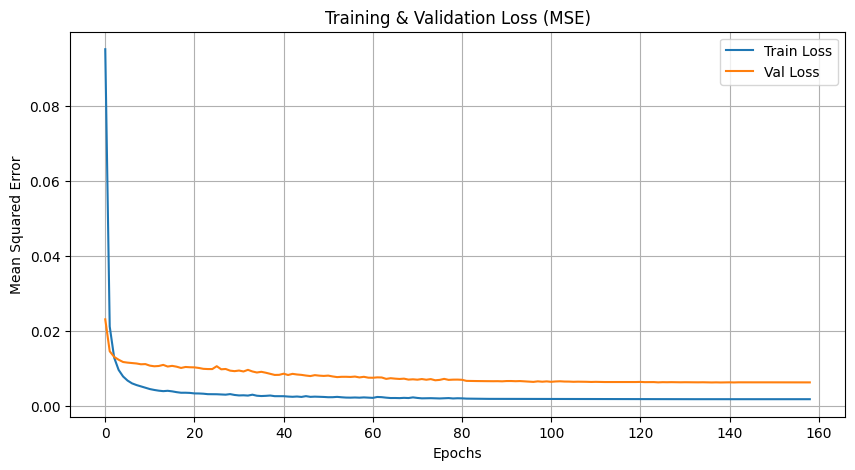

In [11]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import copy

# 設定
lr = 0.001
EPOCHS = 200  # 十分な収束のため30回ほど回します
patience = 20      # 20エポック更新がなければ停止
best_val_loss = float('inf')
early_stop_counter = 0

# 損失関数とオプティマイザ
criterion = nn.MSELoss() # 回帰なのでMSE
optimizer = optim.Adam(model.parameters(), lr=lr)

# 学習率スケジューラ (検証ロスが下がらなくなったら学習率を0.5倍にする)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# ログ用リスト
train_losses = []
val_losses = []

print(f"学習開始 (Device: {device}, Epochs: {EPOCHS})")
start_time = time.time()

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs) # (Batch, 200, 3)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item() * inputs.size(0)
            
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # スケジューラの更新
    scheduler.step(epoch_val_loss)
    
    # 5エポックごとに経過を表示
    if (epoch + 1) % 1 == 0: # 毎回表示に変更（CPUだと進捗が不安になるため）
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss(MSE): {epoch_train_loss:.5f} | Val Loss(MSE): {epoch_val_loss:.5f}")

    # --- Early Stopping check ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict()) # 最良モデルを保存
        early_stop_counter = 0
        # モデル保存（必要ならファイルへ）
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# 最良モデルをロード
model.load_state_dict(best_model_wts)
print("Best Val Loss:", best_val_loss)

total_time = time.time() - start_time
print(f"\n学習完了. 所要時間: {total_time:.1f}秒")

# --- 学習曲線のプロット ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training & Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. テストデータでの推論実行
model.eval()
test_preds = []
test_targets = []

# 推論ループ
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        test_preds.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())

# (サンプル数, 200, 3) に結合
test_preds = np.concatenate(test_preds, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

print(f"Test Predictions Shape: {test_preds.shape}")

# --- 2. 詳細な評価指標の計算 (軸ごとに計算して表にする) ---
axis_names = ['Fx (Mediolateral)', 'Fy (Anterior-Posterior)', 'Fz (Vertical)']
metrics_data = []

for i, name in enumerate(axis_names):
    # Flattenして全時刻・全サンプルのデータを一列にする
    true_flat = test_targets[:, :, i].flatten()
    pred_flat = test_preds[:, :, i].flatten()
    
    # 基本指標
    mse = mean_squared_error(true_flat, pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_flat, pred_flat)
    r2 = r2_score(true_flat, pred_flat)
    corr = np.corrcoef(true_flat, pred_flat)[0, 1]
    
    # %RMSE (Normalized RMSE): レンジ(Max-Min)に対する誤差の割合[%]
    # 生体力学では力のスケールが違う軸を比較するのによく使います
    data_range = np.max(true_flat) - np.min(true_flat)
    n_rmse = (rmse / data_range) * 100 if data_range != 0 else 0.0
    
    metrics_data.append([name, rmse, n_rmse, mae, r2, corr])

# DataFrameで見やすく整形
df_metrics = pd.DataFrame(metrics_data, columns=['Axis', 'RMSE', '%RMSE', 'MAE', 'R2', 'Corr'])

print("\n--- Quantitative Evaluation (Quantitative) ---")
# 小数点以下を見やすくフォーマット表示
print(df_metrics.round(4).to_string(index=False))

# 全体平均の表示（論文のAbstractなどに書く用）
print("\n--- Overall Performance ---")
print(f"Mean %RMSE: {df_metrics['%RMSE'].mean():.2f}%")
print(f"Mean R2:    {df_metrics['R2'].mean():.4f}")

Test Predictions Shape: (2352, 200, 3)

--- Quantitative Evaluation (Quantitative) ---
                   Axis   RMSE   %RMSE    MAE     R2   Corr
      Fx (Mediolateral) 0.0273 10.8681 0.0211 0.5239 0.7587
Fy (Anterior-Posterior) 0.0752 10.9721 0.0486 0.4247 0.6757
          Fz (Vertical) 0.2612 14.8286 0.1682 0.7117 0.8683

--- Overall Performance ---
Mean %RMSE: 12.22%
Mean R2:    0.5534


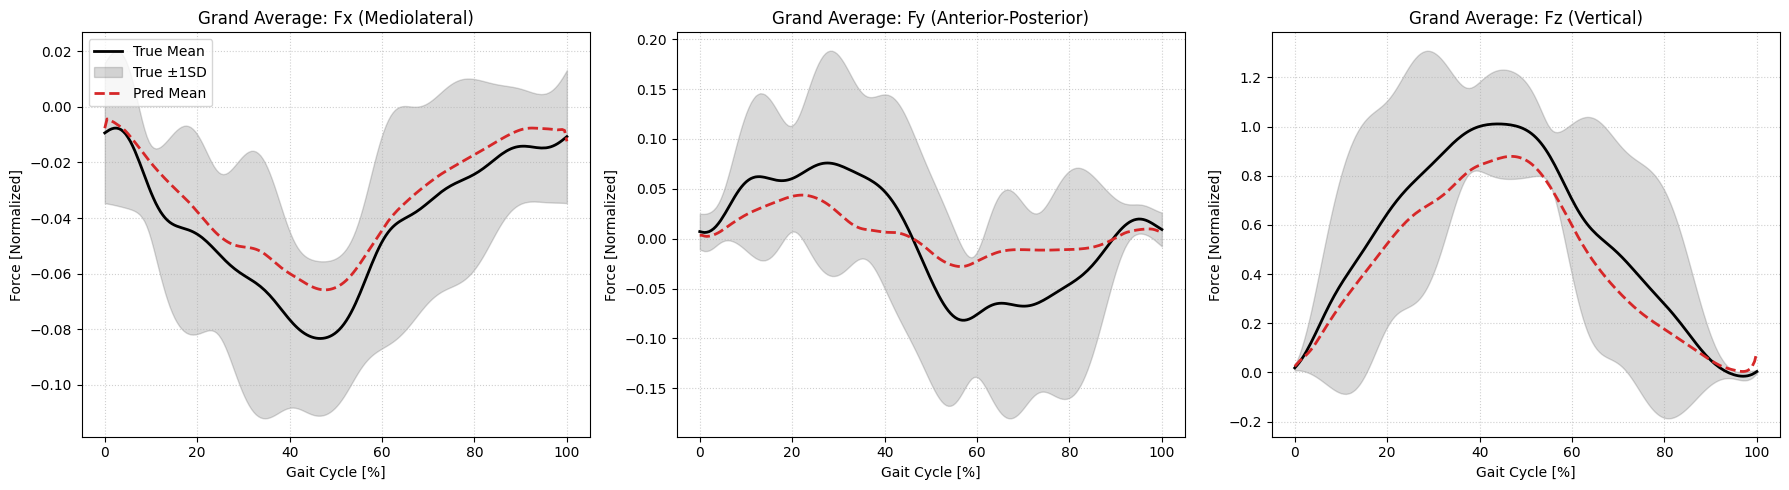

In [16]:
# 平均と標準偏差を計算 (axis=0: サンプル方向に計算)
mean_true = np.mean(test_targets, axis=0)
std_true  = np.std(test_targets, axis=0)

mean_pred = np.mean(test_preds, axis=0)
std_pred  = np.std(test_preds, axis=0)

# プロット作成
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axis_names = ['Fx (Mediolateral)', 'Fy (Anterior-Posterior)', 'Fz (Vertical)']

for i in range(3): # 各軸
    ax = axes[i]
    
    # 時間軸（0~100%に正規化して表示する場合のラベル）
    time_percent = np.linspace(0, 100, 200)
    
    # --- 実測値 (True) ---
    # 平均値を黒実線
    ax.plot(time_percent, mean_true[:, i], color='black', linewidth=2, label='True Mean')
    # ±1SDをグレーの帯で表示
    ax.fill_between(time_percent, 
                    mean_true[:, i] - std_true[:, i], 
                    mean_true[:, i] + std_true[:, i], 
                    color='black', alpha=0.15, label='True ±1SD')
    
    # --- 予測値 (Pred) ---
    # 平均値を赤破線
    ax.plot(time_percent, mean_pred[:, i], color='#d62728', linestyle='--', linewidth=2, label='Pred Mean')
    # 予測のSDも見たければ以下をコメントアウト解除（ごちゃごちゃするので描かないことも多い）
    # ax.fill_between(time_percent, 
    #                 mean_pred[:, i] - std_pred[:, i], 
    #                 mean_pred[:, i] + std_pred[:, i], 
    #                 color='red', alpha=0.1)

    ax.set_title(f"Grand Average: {axis_names[i]}")
    ax.set_xlabel("Gait Cycle [%]")
    ax.set_ylabel("Force [Normalized]")
    ax.grid(True, linestyle=':', alpha=0.6)
    
    if i == 0:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

Plotting for Test Subjects: [10 11]


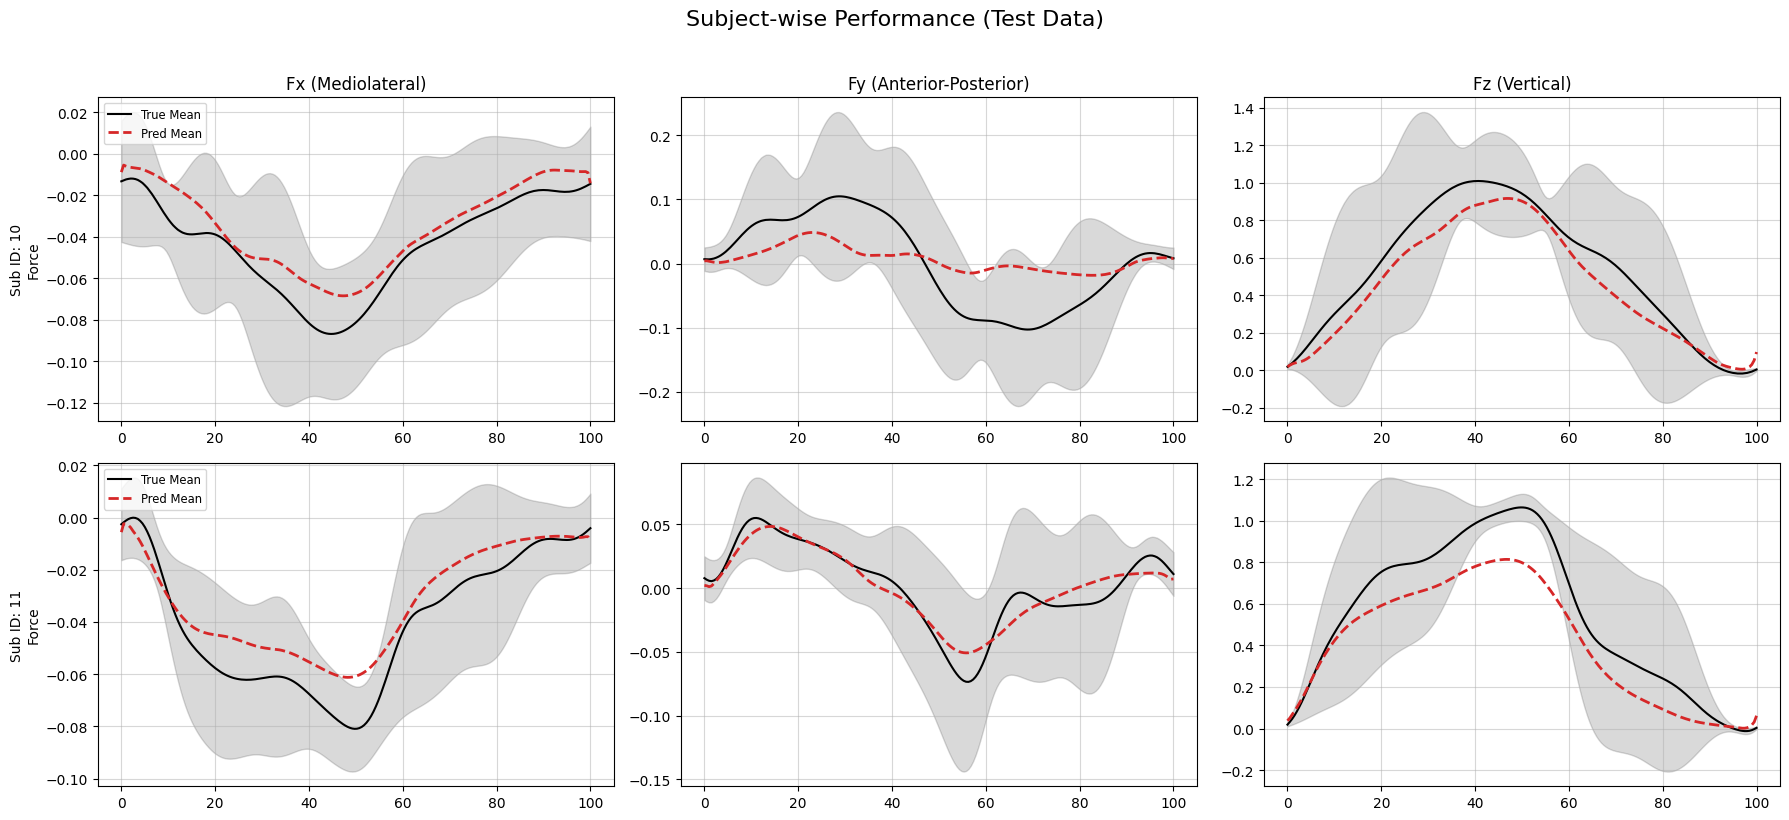

In [17]:
# テストデータに含まれるユニークなIDを取得
test_subject_ids = subject_ids[test_mask]
unique_test_subs = np.unique(test_subject_ids)
num_subs = len(unique_test_subs)

print(f"Plotting for Test Subjects: {unique_test_subs}")

fig, axes = plt.subplots(num_subs, 3, figsize=(18, 4 * num_subs))
# 被験者が1人の場合の処理（axesが1次元配列になるのを防ぐ）
if num_subs == 1: axes = np.expand_dims(axes, axis=0)

for row_idx, sub_id in enumerate(unique_test_subs):
    # その被験者のデータだけ抽出
    indices = np.where(test_subject_ids == sub_id)[0]
    
    sub_targets = test_targets[indices]
    sub_preds   = test_preds[indices]
    
    # その被験者の平均を計算
    sub_mean_true = np.mean(sub_targets, axis=0)
    sub_std_true  = np.std(sub_targets, axis=0)
    sub_mean_pred = np.mean(sub_preds, axis=0)
    
    # RMSEなどをタイトルに入れるとかっこいい
    sub_rmse = np.sqrt(mean_squared_error(sub_targets.reshape(-1,3), sub_preds.reshape(-1,3)))

    for col_idx in range(3):
        ax = axes[row_idx, col_idx]
        time_percent = np.linspace(0, 100, 200)

        # 実測値（平均 ± SD）
        ax.plot(time_percent, sub_mean_true[:, col_idx], color='black', label='True Mean')
        ax.fill_between(time_percent, 
                        sub_mean_true[:, col_idx] - sub_std_true[:, col_idx], 
                        sub_mean_true[:, col_idx] + sub_std_true[:, col_idx], 
                        color='black', alpha=0.15)
        
        # 予測値（平均のみ）
        ax.plot(time_percent, sub_mean_pred[:, col_idx], color='#d62728', linestyle='--', linewidth=2, label='Pred Mean')

        # レイアウト調整
        if col_idx == 0:
            ax.set_ylabel(f"Sub ID: {sub_id}\nForce")
            ax.legend(loc='upper left', fontsize='small')
        
        if row_idx == 0:
            ax.set_title(f"{axis_names[col_idx]}")
            
        ax.grid(True, alpha=0.5)

plt.suptitle(f"Subject-wise Performance (Test Data)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()